# KIT: Mineração de bons cooperados na base de poupadores

## Objtetivo

Prever o valor do cliente poupador PF não cooperado para priorização da força de prospecção

## Metodologia

Com base na margem de contribuição de produtos e serviços, que são receitas de maior fidelização e não causam viés por conta da PDD, selecionamos a base de cooperados PF no período de maturação do ciclo de vida do cliente, sua margem, e com base nela prevemos o valor para os demais clientes poupança a partir das mesmas características dos clientes utilizados como referência.

## Trabalhos de Melhorias

...

## A Fazer

1. Enriquecer informações da base de poupadores para reduzir o mae (erro médio absoluto) e elevar o R²
2. Entender o motivo do abandono tão precoce do tempo de relacionamento. Entender quais os atributos da prestação de serviços mal avaliados na visão do cooperado.
3. Entender onde está o esfoço de relacionamento com o carteirização (relacionamento ativo), está concentrado na base de PJ's? E o relacionamento da base PF, é passivo? Como a rede tem se dedicado para atender esse público, que está fora do radar dos GR's?

## Resultados/Insights

#### KIQ 1: em que momento o cliente sicoob atinge o ápice de seu ciclo de vida?

1. Mais da metade dos cooperados do sicoob (55%) saem da cooperativa antes de completarem 4 anos de relacionamento.
2. Quase 20% abandonam antes mesmo de completar 1 ano de relacionamento.
3. A curva do tempo de relacionamento do cooperado parece suavizar a queda a partir do 60º mês de relacionamento.

#### KIQ 2: qual o valor da margem de contribuição e IAP desse cliente nesse momento?

1. A partir do 60º mês de relacionamento o cooperado rompe a marca dos 2,5 produtos, estabilizando o relacionamento até o 156º mês, onde rompe o 3º produto.

2. Nesse período a margem de contribuição dos seviços rompe a marca dos 300,00 reais a.a., estabilizando o valor com tendência de alta, superando os 500,00 reais a.a. após o 156º mês de relacionamento.

#### KIQ 3: qual o valor do cliente da base sicoob não cooperado com base nos clentes usados como referência?

1. Uma análise de cesta de produtos identificou que quem é poupador normalmente tem maiores chances de contratar: I) Seguro de Vida; II) Crédito consignado; III) Previdência; IV) Seguro Residencial; V) Seguro auto
2. Partindo de um ponto de corte de uma Margem de Serviços mensal estimada de 20,00 reais, estimamos uma base de prospecção de 24.128 poupadores, que juntos totalizam uma margem de serviços anual de 14 milhões de reais.

## Próximos passos sugeridos

1. 
2. 
3. 

## Import Library

In [3]:
# bibliotecas de manipulação
import pandas as pd
import numpy as np

# bibliotecas de visualização
import matplotlib as plt
import seaborn as sns

# bibliotecas de machine learning
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# bibliotecas de balanceamento de dados
from imblearn.under_sampling import RandomUnderSampler

# bibliotecas de preprocessamento
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, QuantileTransformer
from sklearn.compose import ColumnTransformer

# outras bibliotecas
import datetime
import os
import warnings

In [4]:
# opções para o pandas
pd.options.display.max_columns=None
pd.options.display.max_rows=None
pd.options.mode.use_inf_as_na=True
pd.options.display.max_colwidth=None

# opções para visualizações
%matplotlib inline

# opções para Jupyter notebook
warnings.filterwarnings('ignore')

## Importação de bibliotecas ou classes locais

## Definição de Parâmetros

## Importação de Dados

In [5]:
# base cca full para descobrir o ciclo de vida do cooperado
path_cca_full='../data/base_cca_full.csv' # insira aqui o caminho completo do arquivo
df_cca_full=pd.read_csv(path_cca_full, header=0, sep='\t', encoding='utf-16-le', decimal=",")


# base iap para entender qtd de produtos dentro do ciclo de vida
path_iap='../data/base iap.csv'
df_iap=pd.read_csv(path_iap, header=0, sep='\t', encoding='utf-16-le', decimal=","
                  , dtype={'Número CPF/CNPJ': 'object'})
iap_col_delete=['Ano-Mês Movimento', 'Data Movimento']
iap_col_delete.extend([x for x in list(df_iap.columns) if 'Indicador' in x and x not in ['Indicador Acesso Mobile Banking',
                                       'Indicador Produto Conta Capital',
                                       'Indicador Acesso Sicoob Empresarial',
                                       'Indicador Acesso Sicoob Net']])
df_iap.drop(columns=iap_col_delete, inplace=True)


# base cca para coletar cooperados ativos
path_cca='../data/base cca.csv'
df_cca=pd.read_csv(path_cca, header=0, sep='\t', encoding='utf-16-le', decimal=","
                  , dtype={'Número CPF/CNPJ': 'object'})
df_cca.drop(columns=['Data Movimento', 'Data Matricula'], inplace=True)


# base margem de contribuição
path_mc='../data/base mc.csv'
df_mc=pd.read_csv(path_mc, header=0, sep='\t', encoding='utf-16-le', decimal=","
                  , dtype={'Número CPF/CNPJ': 'object'})


# base poupança para identificar se é um poupador frequente
path_pop_mov='../data/base mov poup.csv' # insira aqui o caminho completo do arquivo
df_pop_mov=pd.read_csv(path_pop_mov, header=0, sep='\t', encoding='utf-16-le', decimal=",",
                      dtype={'Número CPF/CNPJ': 'object'})

# base poupança para identificar para coletar estágio atual de associação e saldo
path_pop='../data/base poup.csv' # insira aqui o caminho completo do arquivo
df_pop=pd.read_csv(path_pop, header=0, sep='\t', encoding='utf-16-le', decimal=",",
                      dtype={'Número CPF/CNPJ': 'object'})

df_pop['Indicador Associado']=df_pop['Indicador Associado'].map({'Não':0, 'Sim':1})

# base para coletar lancamentos em pop
path_lancamento='../data/base lancamento.csv' # insira aqui o caminho completo do arquivo
df_lancamento=pd.read_csv(path_lancamento, header=0, sep='\t', encoding='utf-16-le', decimal=",",
                      dtype={'Número CPF/CNPJ': 'object'})
df_lancamento.drop(columns='Data Movimento', inplace=True)

### Questão 1: descobrindo o ciclo de vida do cooperado sicoob

O gráfico a seguir mostra a frequência acumulada do tempo de vida de um cliente sicoob. É possível visualizar que mais de 50% dos cooperados abandonam a cooperativa antes de completar 4 anos de associação. Em função disso vamos desconsiderar a margem de contribuição dos cooperados com tempo de associação menor que esta, pois é um indício de que o potencial de receita gerada por ele não tenha sido explorada por completo.

In [6]:
# tratando base cca full
df_cca_full=df_cca_full[df_cca_full['Situação Conta Capital'].isin(['ATIVO','DEMITIDO'])]
df_cca_full['Situação Conta Capital'].value_counts()

ATIVO       290743
DEMITIDO     51512
Name: Situação Conta Capital, dtype: int64

In [7]:
# balanceando dados aleatoriamente para obter a mesma qtd de ativos e demitidos
rs_cca=RandomUnderSampler(random_state=42)
df_cca_full=rs_cca.fit_resample(df_cca_full, df_cca_full['Situação Conta Capital'])[0]
df_cca_full['Situação Conta Capital'].value_counts()

ATIVO       51512
DEMITIDO    51512
Name: Situação Conta Capital, dtype: int64

Text(0.5, 1.0, 'Quantos meses um cooperado PF fica no Sicoob? (Freq Acumulada)')

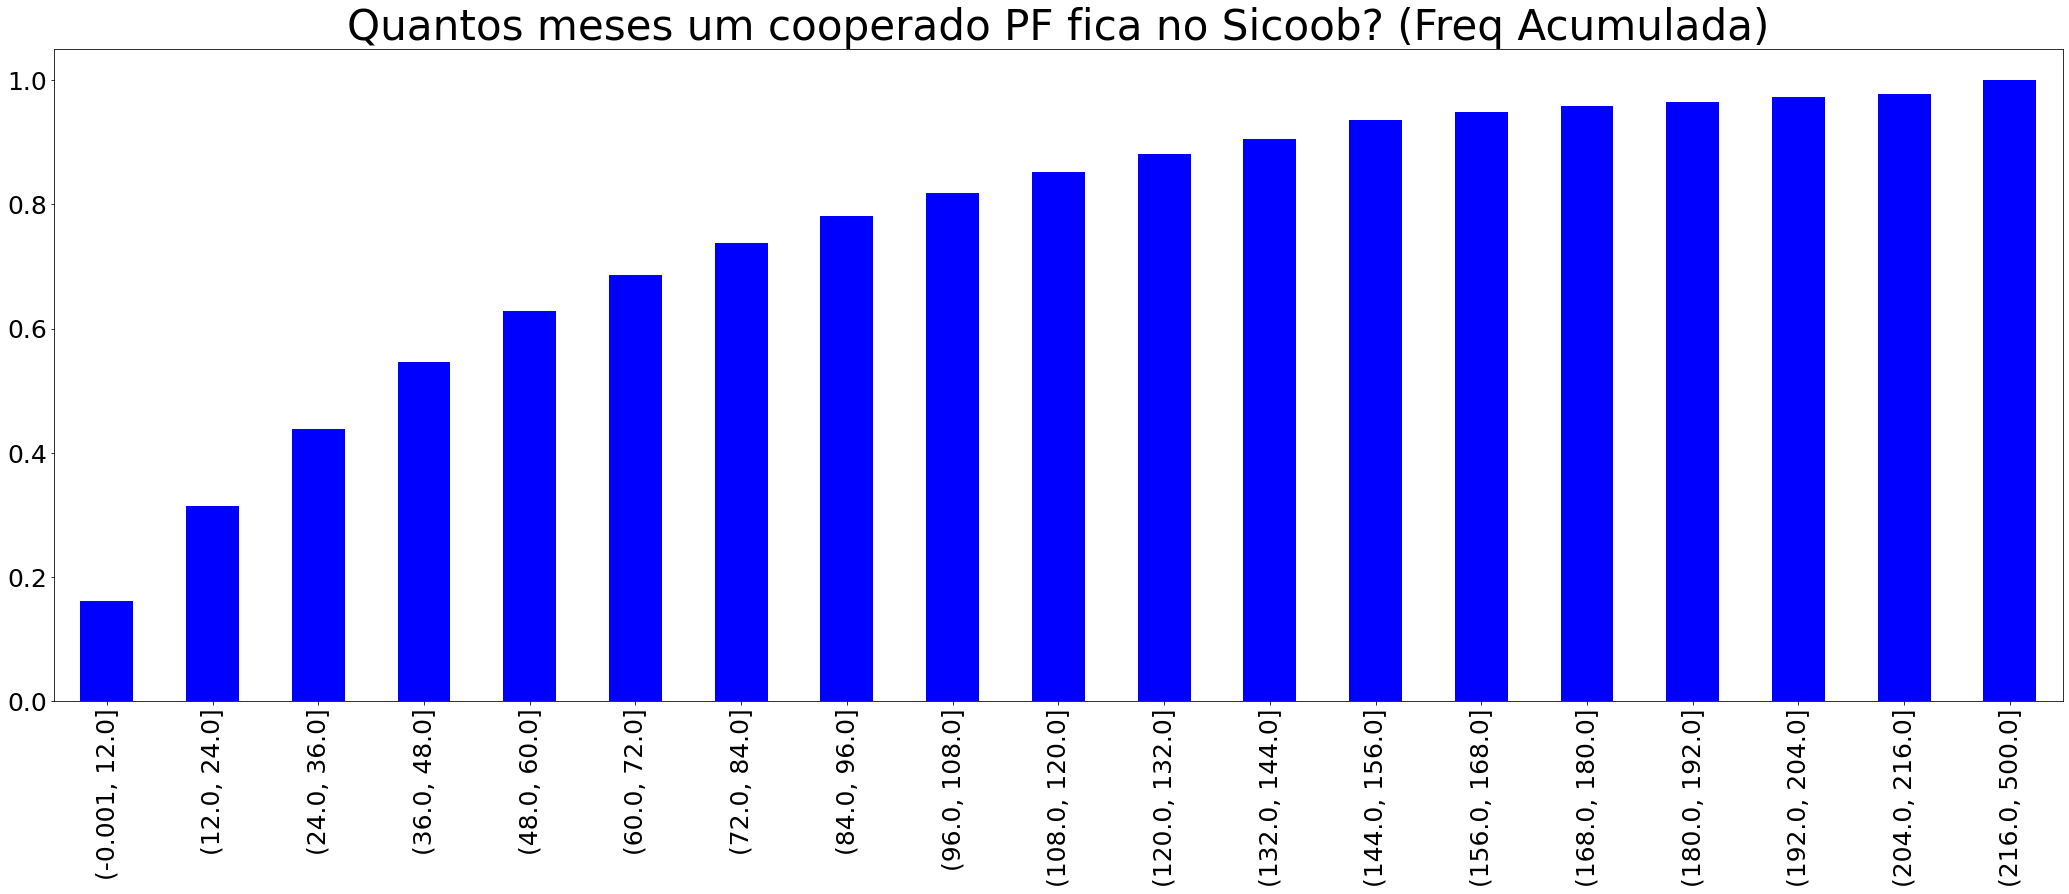

In [8]:
# Entendendo quantos anos um cooperado fica no sicoob
bins_tmp_assoc=[0,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180,192,204,216,500]
out = pd.cut(df_cca_full['Qtd Meses Associação'], bins=bins_tmp_assoc, include_lowest=True)
stat=out.value_counts(sort=False)/df_cca_full.shape[0]
stat=stat.cumsum()/stat.sum()
ax = stat.plot.bar(rot=90, color="b", figsize=(36,12))
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_title('Quantos meses um cooperado PF fica no Sicoob? (Freq Acumulada)', fontsize=42)

Text(0.5, 1.0, 'Quantos meses um cooperado PF fica no Sicoob?')

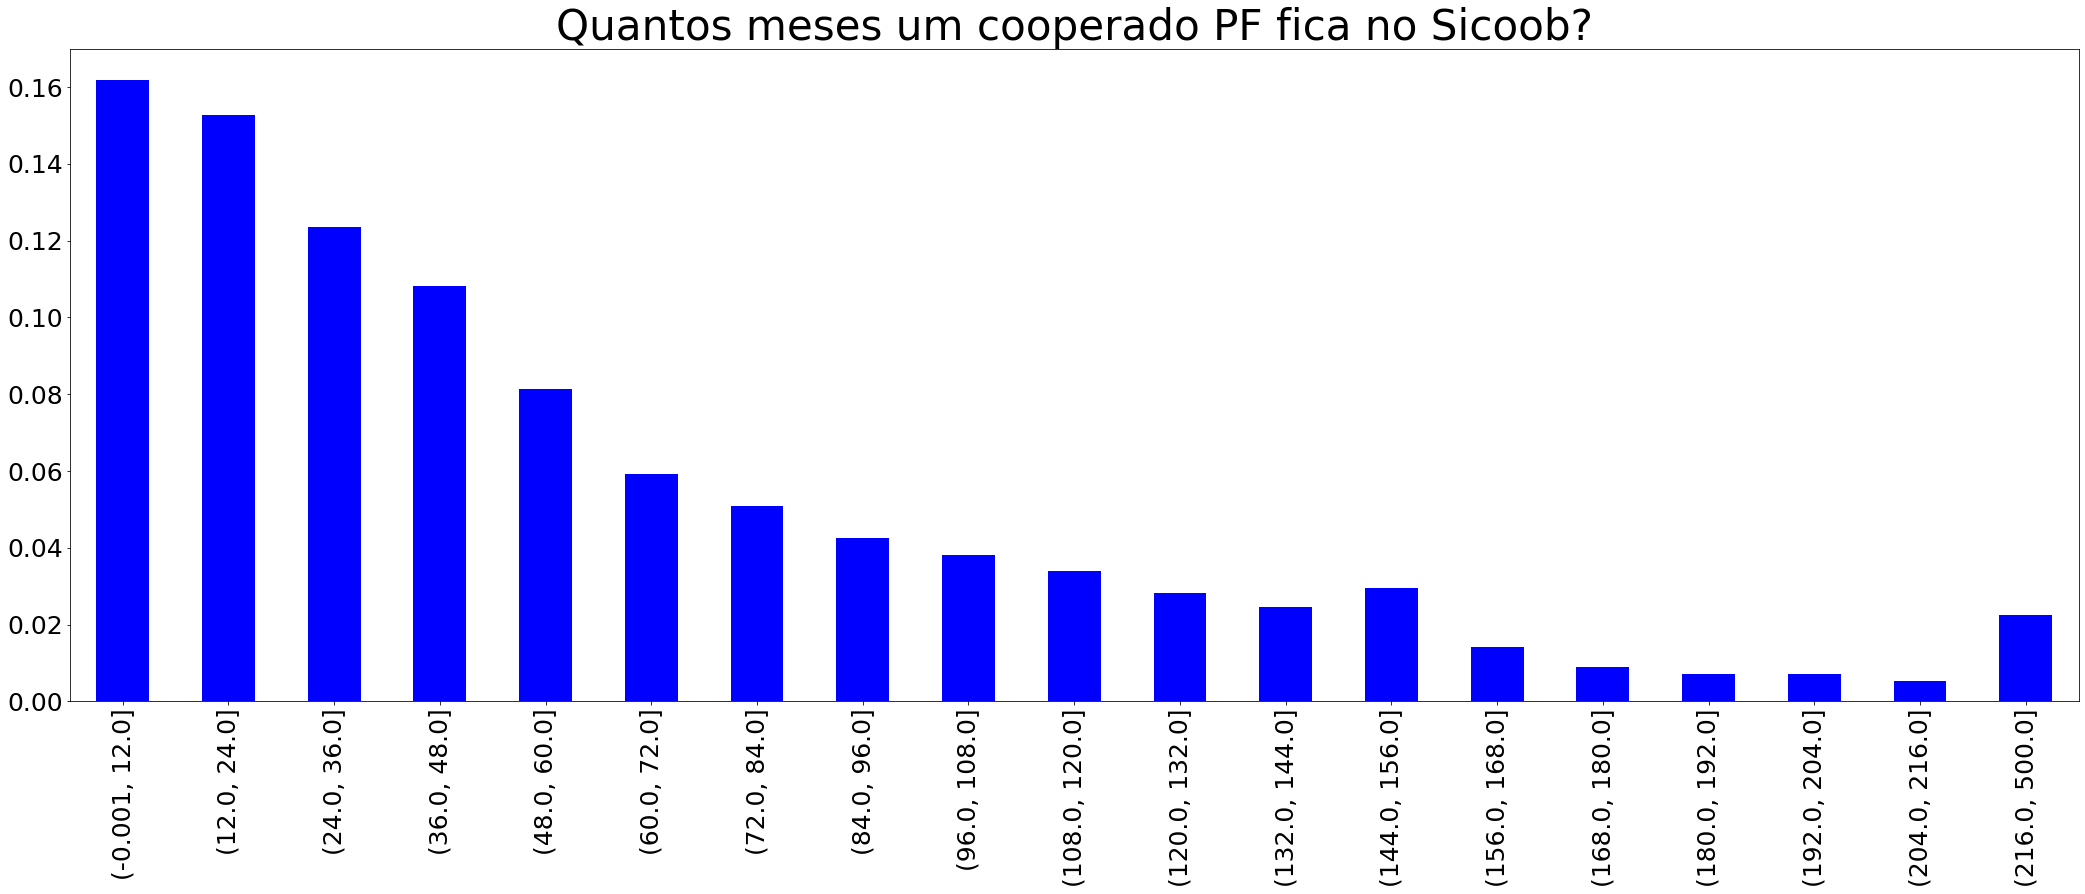

In [9]:
out = pd.cut(df_cca_full['Qtd Meses Associação'], bins=bins_tmp_assoc, include_lowest=True)
stat=out.value_counts(sort=False)/df_cca_full.shape[0]
ax = stat.plot.bar(rot=90, color="b", figsize=(36,12))
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_title('Quantos meses um cooperado PF fica no Sicoob?', fontsize=42)

### Questão 1: descobrindo a qtde de produtos do ciclo de vida do cliente sicoob

O gráfico abaixo plota a qtde média de produtos por tempo de relacionamento. Pela análise gráfica o cooperado leva no mínimo 5 anos para estabilizar em 2,5 produtos de relacionamento, e no mínimo 13 anos para romper a marca de 3 produtos.

In [10]:
# unindo os dados de iap aos dados do conta capital de mesma data para obter o tempo de associação do cooperado
df=df_iap.merge(df_cca, how='left', 
                left_on=['Número Cooperativa', 'Número CPF/CNPJ'], 
                right_on=['Número Cooperativa', 'Número CPF/CNPJ'])

df['Qtd Meses Associação'].fillna(0, inplace=True)

# binando qtd meses associação
df['BINN Qtd Meses Associação']=pd.cut(df['Qtd Meses Associação']
             , bins=bins_tmp_assoc, include_lowest=True)

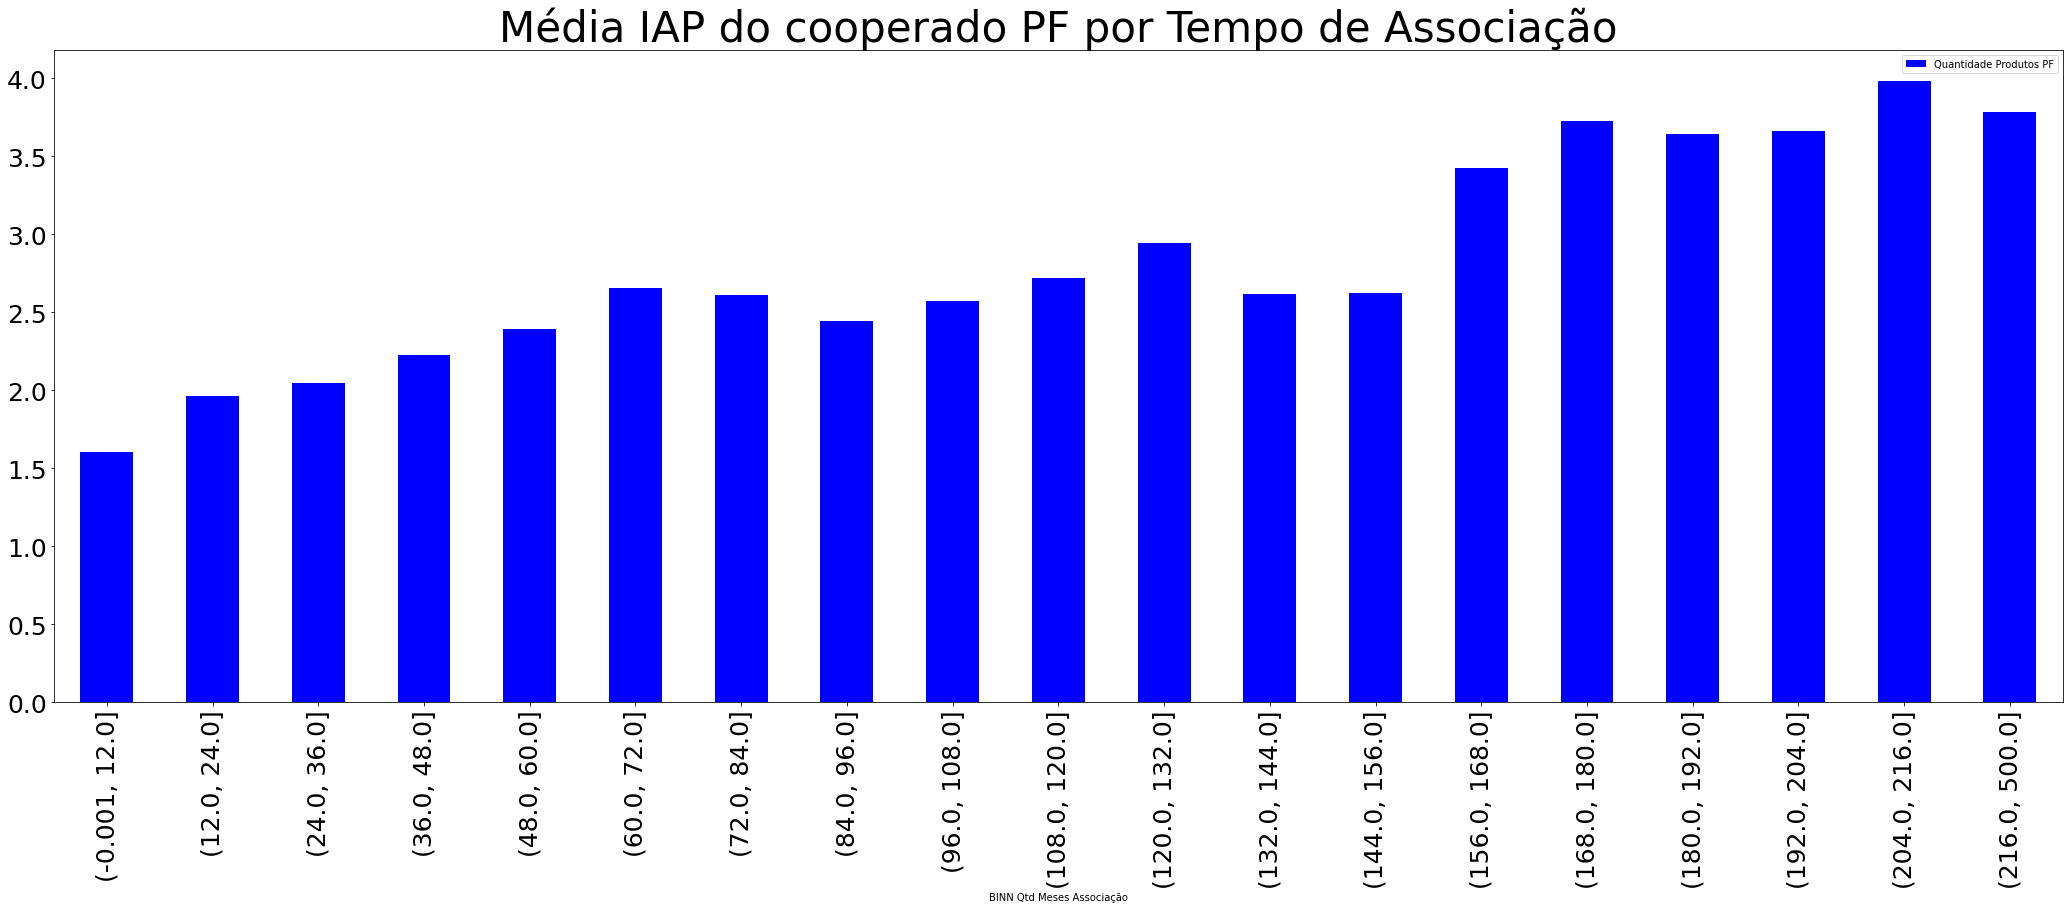

In [11]:
# Entendendo quantos anos um cooperado fica no sicoob
out=df[df['Indicador Produto Conta Capital']=='SIM'][['Quantidade Produtos PF', 'BINN Qtd Meses Associação']]
stat=out.groupby(by='BINN Qtd Meses Associação').mean().reset_index()
#stat['Quantidade Produtos PF']=stat['Quantidade Produtos PF'].apply(lambda x: round(x))
ax = stat.plot.bar(x='BINN Qtd Meses Associação', y='Quantidade Produtos PF',rot=90, color="b", figsize=(36,12))
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_title('Média IAP do cooperado PF por Tempo de Associação', fontsize=42)
df.drop(columns=['BINN Qtd Meses Associação'], inplace=True)

### Questão 1: descobrindo a margem de contribuição do ciclo de vida do cliente sicoob

Pela análise dos gráficos do IAP, Ciclo de Vida do Cooperado e Margem Anual de Contribuição, há indícios de estabilização do relacionamento do cliente a partir do 5º ano de relacionamento.
Para fins de nosso estudo, e considerando que a margem de contribuição relativamente se estabiliza entre 5 e 13 anos de relacionamento, vamos considerar os cooperados com essa faixa de associação para usarmos como referência para descobrir o potencial de margem dos poupadores não cooperados.

In [12]:
df=df.merge(df_mc, how='left', 
                left_on=['Número Cooperativa', 'Número CPF/CNPJ'], 
                right_on=['Número Cooperativa', 'Número CPF/CNPJ'])

df['Resultado PDS Ano'].fillna(0, inplace=True)
df['Média Anual Resultado PDS'].fillna(0, inplace=True)

# binando qtd meses associação
df['BINN Qtd Meses Associação']=pd.cut(df['Qtd Meses Associação']
             , bins=bins_tmp_assoc, include_lowest=True)

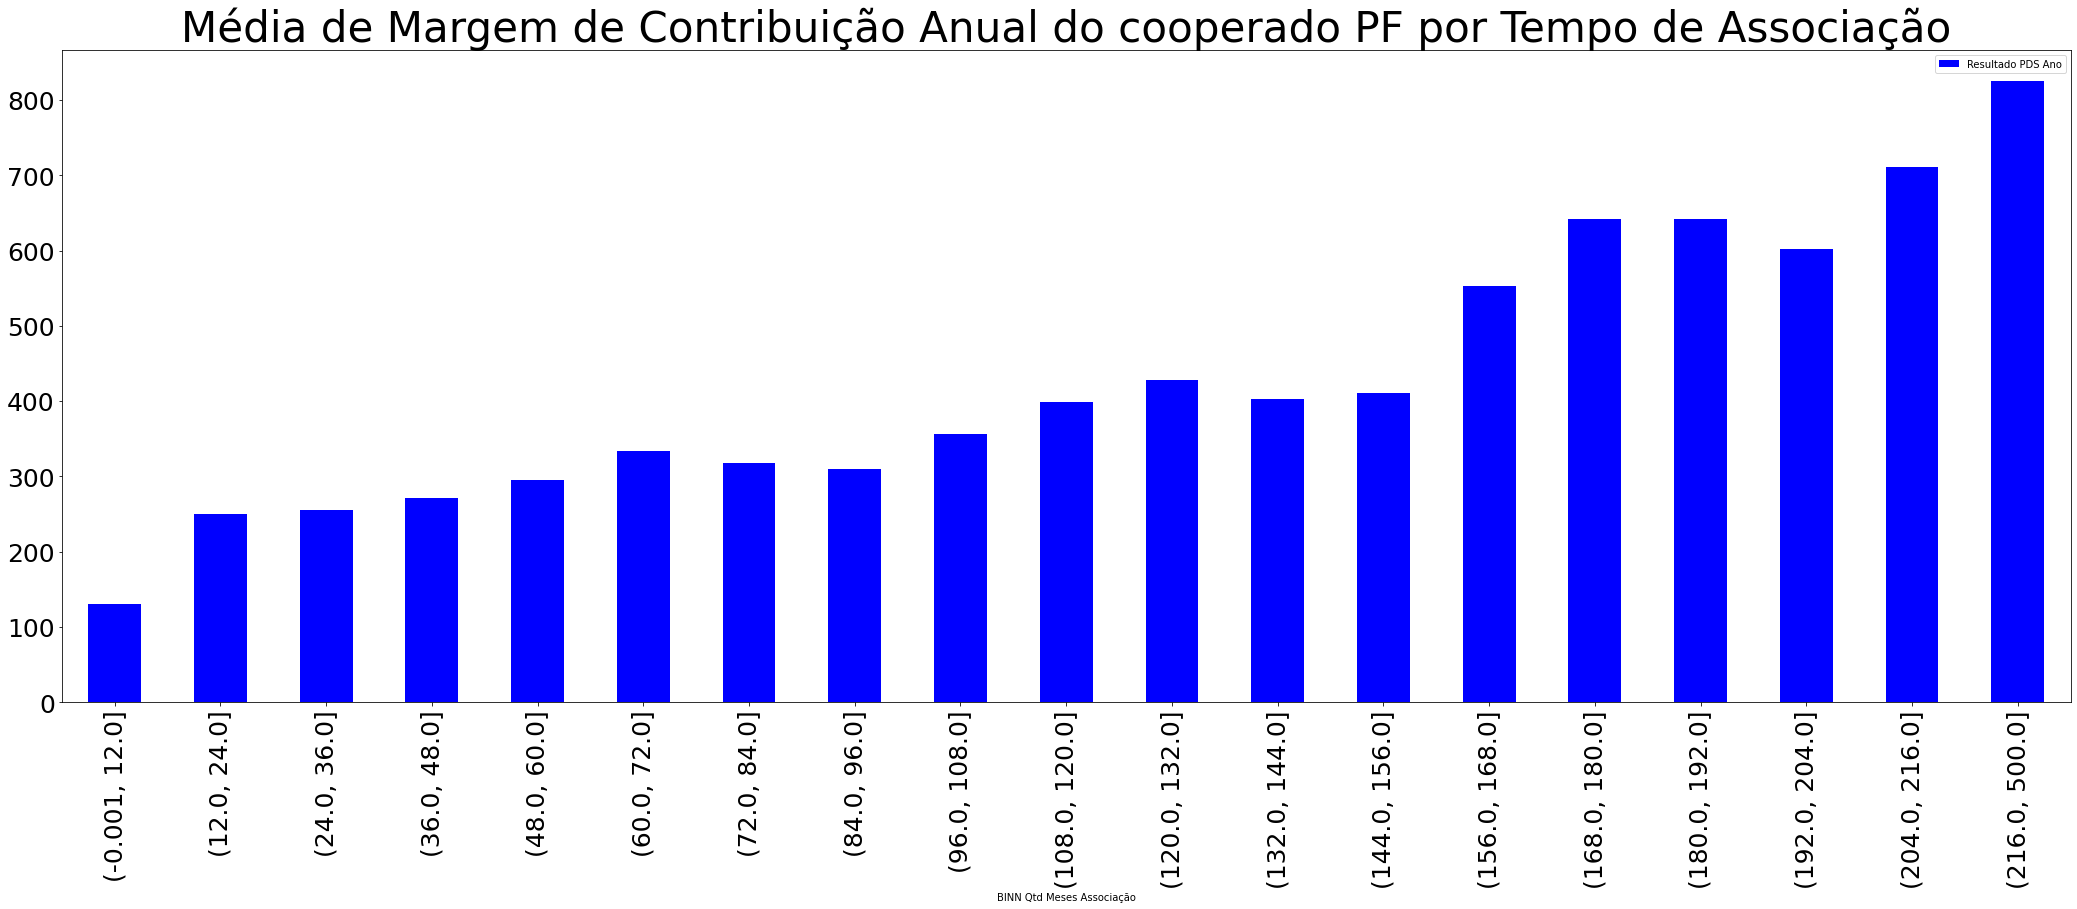

In [13]:
# Entendendo a média da mc por tempo de associação
out=df[df['Indicador Produto Conta Capital']=='SIM'][['Resultado PDS Ano', 'BINN Qtd Meses Associação']]
stat=out.groupby(by='BINN Qtd Meses Associação').mean().reset_index()
#stat['Quantidade Produtos PF']=stat['Quantidade Produtos PF'].apply(lambda x: round(x))
ax = stat.plot.bar(x='BINN Qtd Meses Associação', y='Resultado PDS Ano',rot=90, color="b", figsize=(36,12))
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_title('Média de Margem de Contribuição Anual do cooperado PF por Tempo de Associação', fontsize=42)
df.drop(columns=['BINN Qtd Meses Associação'], inplace=True)

### Questão 3: Descobrindo o valor do poupador não cooperado

In [14]:
# unindo dados de movimentação do poupador no último ano
df=df.merge(df_pop_mov, how='left', 
                left_on=['Número Cooperativa', 'Número CPF/CNPJ'], 
                right_on=['Número Cooperativa', 'Número CPF/CNPJ'])

df['Valor Médio Depósito Mensal'].fillna(0, inplace=True)
df['Frequência Depósito Mensal'].fillna(0, inplace=True)

# unindo dados de saldo de poupança
df=df.merge(df_pop, how='left', 
                left_on=['Número Cooperativa', 'Número CPF/CNPJ'], 
                right_on=['Número Cooperativa', 'Número CPF/CNPJ'])

df['Indicador Poupador']=df['Valor Saldo Diário'].apply(lambda x: 0 if np.isnan(x) else 1)
df['Indicador Associado'].fillna(0, inplace=True)
df['Valor Saldo Diário'].fillna(0, inplace=True)
df['Descrição Grupo Econômico'].fillna('NÃO INFORMADO', inplace=True)
df['Valor Bem Imóvel'].fillna(0, inplace=True)
df['Valor Bem Móvel'].fillna(0, inplace=True)

# unindo dados de movimentação lançamentos no último ano
df=df.merge(df_lancamento, how='left', 
                left_on=['Número Cooperativa', 'Número CPF/CNPJ'], 
                right_on=['Número Cooperativa', 'Número CPF/CNPJ'])
df['Vendas Cartão Credenciadora Anual'].fillna(0, inplace=True)

In [15]:
# gerando dataframe de poupadores
df_base=df.loc[:,[x for x in list(df.columns) if x not in ['Data Início Relacionamento',
                                                          'Quantidade Produtos PF',
                                                          'Indicador Acesso Sicoob Empresarial',
                                                          'Indicador Produto Conta Capital',
                                                          'Média Anual Resultado PDS',
                                                          ]]].copy()

# removendo registros com indícios de erro no cadastro da renda
df_base.drop(df_base[df_base['Renda Bruta Mensal']>6000000000].index, inplace=True)

# removendo registros com indícios de cooperados falecidos
df_base.drop(df_base[(df_base['Idade']>110) &
                (df_base['Frequência Depósito Mensal']==0.0) &
                (df_base['Valor Saldo Diário']<=70)].index, inplace=True)

# filtrando apenas poupadores
df_base=df[df['Indicador Poupador']==1]
df_base.reset_index(inplace=True, drop=True)

# gerando base de poupadores a ser utilizado para cálculo do valor
#df_base_poup=df_base[(df_base['Indicador Associado']==1.0) & 
#               (df_base['Qtd Meses Associação']>=60) &
#                (df_base['Qtd Meses Associação']<=156)]

df_base.shape

(236799, 35)

In [16]:
# checando dados de cooperados poupadores
out=df_base[df_base['Indicador Associado']==1.0].describe()

for i in list(out.columns):
    out[i]=round(out[i],0)
out['Renda Bruta Mensal']=out['Renda Bruta Mensal'].astype('int64')
out

,Número Cooperativa,Número PA,Tempo Relacionamento,Idade,Quantidade Dependentes,Renda Bruta Mensal,Quantidade Produtos PF,Qtd Meses Associação,Resultado PDS Ano,Média Anual Resultado PDS,Valor Médio Depósito Mensal,Frequência Depósito Mensal,Indicador Associado,Valor Bem Imóvel,Valor Bem Móvel,Valor Saldo Diário,Indicador Poupador,Vendas Cartão Credenciadora Anual
count,86824.0,86824.0,86824.0,86824.0,86824.0,86824,86824.0,86824.0,86824.0,86824.0,86824.0,86824.0,86824.0,86824.0,86824.0,86824.0,86824.0,86824.0
mean,3020.0,9.0,81.0,40.0,0.0,75086,3.0,64.0,404.0,35.0,1197.0,2.0,1.0,44311.0,13343.0,5370.0,1.0,22.0
std,57.0,9.0,64.0,16.0,1.0,21009991,3.0,62.0,851.0,71.0,74353.0,3.0,0.0,323945.0,123148.0,27835.0,0.0,921.0
min,3001.0,0.0,0.0,0.0,0.0,0,0.0,0.0,-1373.0,-114.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
25%,3007.0,3.0,31.0,28.0,0.0,1000,1.0,17.0,25.0,3.0,0.0,0.0,1.0,0.0,0.0,6.0,1.0,0.0
50%,3008.0,8.0,64.0,38.0,0.0,1800,3.0,41.0,203.0,18.0,14.0,1.0,1.0,0.0,0.0,109.0,1.0,0.0
75%,3009.0,12.0,116.0,51.0,0.0,3023,5.0,99.0,469.0,40.0,547.0,3.0,1.0,0.0,0.0,2014.0,1.0,0.0
max,3260.0,97.0,381.0,120.0,12.0,6190783759,14.0,381.0,62259.0,5188.0,21867364.0,12.0,1.0,30053515.0,22128073.0,4641283.0,1.0,121402.0


In [17]:
# checando dados de não cooperados poupadores
out=df_base[df_base['Indicador Associado']==0.0].describe()

for i in list(out.columns):
    out[i]=round(out[i],0)
out['Renda Bruta Mensal']=out['Renda Bruta Mensal'].astype('int64')
out

,Número Cooperativa,Número PA,Tempo Relacionamento,Idade,Quantidade Dependentes,Renda Bruta Mensal,Quantidade Produtos PF,Qtd Meses Associação,Resultado PDS Ano,Média Anual Resultado PDS,Valor Médio Depósito Mensal,Frequência Depósito Mensal,Indicador Associado,Valor Bem Imóvel,Valor Bem Móvel,Valor Saldo Diário,Indicador Poupador,Vendas Cartão Credenciadora Anual
count,149975.0,149975.0,149975.0,149975.0,149975.0,149975,149975.0,149975.0,149975.0,149975.0,149975.0,149975.0,149975.0,149975.0,149975.0,149975.0,149975.0,149975.0
mean,3020.0,8.0,63.0,39.0,0.0,929,1.0,0.0,1.0,0.0,682.0,2.0,0.0,4351.0,838.0,4139.0,1.0,20.0
std,55.0,7.0,42.0,19.0,1.0,4940,1.0,4.0,28.0,4.0,3945.0,3.0,0.0,67764.0,15424.0,18595.0,0.0,1059.0
min,3001.0,0.0,0.0,0.0,0.0,0,0.0,0.0,-481.0,-147.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25%,3007.0,3.0,37.0,26.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0
50%,3008.0,7.0,59.0,37.0,0.0,678,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,0.0,67.0,1.0,0.0
75%,3009.0,12.0,79.0,52.0,0.0,1108,1.0,0.0,0.0,0.0,480.0,4.0,0.0,0.0,0.0,1802.0,1.0,0.0
max,3260.0,97.0,381.0,120.0,30.0,1000000,9.0,272.0,3905.0,434.0,763555.0,12.0,0.0,10850000.0,3311151.0,3983811.0,1.0,298428.0


1. Renda Bruta: alta variabilidade, talvez normalização quantílica, checar.
2. Margem PDS Ano: 3.951 valores negativos, retirar margem do RDC

## Pré Processamento de Dados

In [18]:
df_base.head(3)

,Número Cooperativa,Número CPF/CNPJ,Nome Cliente,Número PA,Nome PA,Escolaridade,Estado Civil,Descrição Categoria Produtor Rural,Data Início Relacionamento,Tempo Relacionamento,Idade,Profissão,Quantidade Dependentes,Renda Bruta Mensal,Sexo,Tipo Renda,Vínculo Empregatício,Município,Quantidade Produtos PF,Indicador Acesso Mobile Banking,Indicador Acesso Sicoob Empresarial,Indicador Acesso Sicoob Net,Indicador Produto Conta Capital,Qtd Meses Associação,Resultado PDS Ano,Média Anual Resultado PDS,Valor Médio Depósito Mensal,Frequência Depósito Mensal,Indicador Associado,Descrição Grupo Econômico,Valor Bem Imóvel,Valor Bem Móvel,Valor Saldo Diário,Indicador Poupador,Vendas Cartão Credenciadora Anual
0,3010,12744580724,THALICA LORENZONI CAMINOTTE,4,SICOOB - PA MARECHAL FLORIANO,ENSINO FUNDAMENTAL COMPLETO (ANTIGO 1º GRAU),SOLTEIRO(A),NÃO SE APLICA,2015-08-07,59,28,ESTUDANTE,0,0.0,F,NÃO INFORMADO,OUTRAS OCUPAÇÕES NÃO REMUNERADAS,CARIACICA,1,NÃO,NÃO,NÃO,NÃO,0.0,0.0,0.0,0.000000,0.0,0.0,NÃO INFORMADO,0.0,0.0,2325.07,1,0.0
1,3010,19601503757,SEBASTIAO OLINTO FARIA DONATO,2,SICOOB - PA BREJETUBA,ENSINO MÉDIO INCOMPLETO (ANTIGO 2º GRAU),SOLTEIRO(A),NÃO SE APLICA,2020-06-16,0,23,TRABALHADOR AGROPECUÁRIO EM GERAL,0,850.0,M,OUTROS,AUTÔNOMO,BREJETUBA,1,NÃO,NÃO,NÃO,NÃO,0.0,0.0,0.0,500.000000,1.0,0.0,NÃO INFORMADO,0.0,0.0,0.00,1,0.0
2,3008,12028683716,CRISTIANE PROSCHOLDT COELHO,8,SICOOB - PA DOMINGOS MARTINS,ENSINO FUNDAMENTAL COMPLETO (ANTIGO 1º GRAU),CASADO(A),NÃO SE APLICA,2015-08-07,59,35,PRODUTORES AGRÍCOLAS,0,0.0,F,NÃO INFORMADO,OUTRAS OCUPAÇÕES NÃO REMUNERADAS,DOMINGOS MARTINS,1,NÃO,NÃO,NÃO,NÃO,0.0,0.0,0.0,158.218333,1.0,0.0,NÃO INFORMADO,0.0,0.0,18265.78,1,0.0


In [19]:
features=['Escolaridade', 'Profissão','Estado Civil', 'Descrição Categoria Produtor Rural',
         'Idade','Quantidade Dependentes','Renda Bruta Mensal','Sexo',
         'Tipo Renda','Município','Vínculo Empregatício','Indicador Acesso Mobile Banking',
         'Indicador Acesso Sicoob Net','Valor Médio Depósito Mensal', 'Frequência Depósito Mensal',
         'Valor Saldo Diário','Descrição Grupo Econômico','Valor Bem Imóvel','Valor Bem Móvel',
         'Vendas Cartão Credenciadora Anual']
target=['Média Anual Resultado PDS']

df_base_prep=df_base[features].copy()
df_base_prep['TARGET']=df_base[target]
# retirado 'Vínculo Empregatício' por colinearidade com profissão

In [20]:
# setando tipo de transformação de variáveis
features_num=[x for x in list(df_base_prep.select_dtypes(exclude=['object']).columns) if x !='TARGET']
features_label=['Sexo', 'Indicador Acesso Mobile Banking','Indicador Acesso Sicoob Net']
#features_onehot=['Sexo', 'Indicador Acesso Mobile Banking','Indicador Acesso Sicoob Net','Escolaridade', 'Estado Civil', 'Descrição Categoria Produtor Rural', 'Vínculo Empregatício', 'Tipo Renda']
features_cat=[x for x in list(df_base_prep.columns) if x not in features_num+features_label+['TARGET']]

In [21]:
# transformando features

sc = StandardScaler()
le = LabelEncoder()
qt = QuantileTransformer(n_quantiles=100)
on = OneHotEncoder()

# normalizando variáveis numericas
df_base_prep[features_num]=sc.fit_transform(df_base_prep[features_num])
#df_base_prep[features_num]=qt.fit_transform(df_base_prep[features_num])

# codificando labels de variáveis binárias
for i in features_label:
    df_base_prep[i]=le.fit_transform(df_base_prep[i])
    
# transformando variáveis categóricas
for i in features_cat:
    feature_dic=df_base_prep.groupby(by=[i])['TARGET'].mean().to_dict()
    df_base_prep[i]=df_base_prep[i].map(feature_dic)

In [22]:
df_base_prep.head(3)

,Escolaridade,Profissão,Estado Civil,Descrição Categoria Produtor Rural,Idade,Quantidade Dependentes,Renda Bruta Mensal,Sexo,Tipo Renda,Município,Vínculo Empregatício,Indicador Acesso Mobile Banking,Indicador Acesso Sicoob Net,Valor Médio Depósito Mensal,Frequência Depósito Mensal,Valor Saldo Diário,Descrição Grupo Econômico,Valor Bem Imóvel,Valor Bem Móvel,Vendas Cartão Credenciadora Anual,TARGET
0,13.261020,2.479626,7.243248,10.42394,-0.638331,-0.410453,-0.002210,0,0.426899,16.137257,2.053806,0,0,-0.019290,-0.712329,-0.100959,10.228782,-0.092994,-0.071533,-0.020106,0.0
1,7.032191,8.386332,7.243248,10.42394,-0.921838,-0.410453,-0.002143,1,15.318671,10.260308,11.380574,0,0,-0.008211,-0.406661,-0.204586,10.228782,-0.092994,-0.071533,-0.020106,0.0
2,13.261020,2.258363,23.826021,10.42394,-0.241421,-0.410453,-0.002210,0,0.426899,16.464490,2.053806,0,0,-0.015784,-0.406661,0.609515,10.228782,-0.092994,-0.071533,-0.020106,0.0


In [23]:
df_base_prep.shape

(236799, 21)

#### Preparando conjunto de dado de treino e teste com base em cooperados que tenham entre 60 e 156 meses de relacionamento

In [24]:
df_base.head(1)

,Número Cooperativa,Número CPF/CNPJ,Nome Cliente,Número PA,Nome PA,Escolaridade,Estado Civil,Descrição Categoria Produtor Rural,Data Início Relacionamento,Tempo Relacionamento,Idade,Profissão,Quantidade Dependentes,Renda Bruta Mensal,Sexo,Tipo Renda,Vínculo Empregatício,Município,Quantidade Produtos PF,Indicador Acesso Mobile Banking,Indicador Acesso Sicoob Empresarial,Indicador Acesso Sicoob Net,Indicador Produto Conta Capital,Qtd Meses Associação,Resultado PDS Ano,Média Anual Resultado PDS,Valor Médio Depósito Mensal,Frequência Depósito Mensal,Indicador Associado,Descrição Grupo Econômico,Valor Bem Imóvel,Valor Bem Móvel,Valor Saldo Diário,Indicador Poupador,Vendas Cartão Credenciadora Anual
0,3010,12744580724,THALICA LORENZONI CAMINOTTE,4,SICOOB - PA MARECHAL FLORIANO,ENSINO FUNDAMENTAL COMPLETO (ANTIGO 1º GRAU),SOLTEIRO(A),NÃO SE APLICA,2015-08-07,59,28,ESTUDANTE,0,0.0,F,NÃO INFORMADO,OUTRAS OCUPAÇÕES NÃO REMUNERADAS,CARIACICA,1,NÃO,NÃO,NÃO,NÃO,0.0,0.0,0.0,0.0,0.0,0.0,NÃO INFORMADO,0.0,0.0,2325.07,1,0.0


In [25]:
i=df_base[(df_base['Indicador Associado']==1.0) &
          (df_base['Qtd Meses Associação']>=60) &
          (df_base['Qtd Meses Associação']<=156) #(df_base['Resultado PDS Ano']<=2295)
          ].index
i.shape

(26027,)

In [26]:
# selecionando base de poupadores não associados
p=df_base[(df_base['Indicador Associado']==0.0) &
          (df_base['Indicador Poupador']==1)
          ].index
p.shape

(149975,)

In [27]:
# separando bases de treino e teste
X = df_base_prep.iloc[i,:-1]
Y = df_base_prep.iloc[i,-1]

In [28]:
# limitando outliers
std=round(np.std(Y),2)
avg=round(np.mean(Y),2)
lim = round(avg + 2 * std)
print(std, '|', avg, '|', lim)

73.54 | 43.17 | 190


In [29]:
X_train, X_test, Y_train, Y_test =train_test_split(X, Y, test_size = 0.2, random_state = 0)
X.shape

(26027, 20)

### Criando arquitetura de rede neural

In [173]:
# inicializando ANN
ann = tf.keras.models.Sequential()

# adicionando Dense layers
ann.add(tf.keras.layers.Dense(units=10, activation='relu'))
ann.add(tf.keras.layers.Dense(units=10, activation='relu'))

# adicionando output layer
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))

# compilando arquitetura
ann.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])


In [174]:
# treinando rede
ann.fit(X_train, Y_train, batch_size = 32, epochs =60)

Epoch 1/60

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

651/651 [==============================] - 0s 764us/step - loss: 3631.5144 - mae: 29.8524
Epoch 2/60
651/651 [==============================] - 0s 692us/step - loss: 3356.7532 - mae: 28.2320
Epoch 3/60
651/651 [==============================] - 0s 726us/step - loss: 3271.1174 - mae: 27.6390
Epoch 4/60
651/651 [==============================] - 0s 671us/step - loss: 3149.1104 - mae: 26.7219
Epoch 5/60
651/651 [==============================] - 0s 637us/step - loss: 2987.6694 - mae: 25.8295
Epo

In [175]:
Y_pred = ann.predict(X_test)
Y_pred = ann.predict(X_test)
r2_score(Y_test, Y_pred)
print('R²: ', round(r2_score(Y_test, Y_pred),2), '|', 'mae:', round(mean_absolute_error(Y_test, Y_pred),2))

R²:  0.57 | mae: 24.22


Testando com regressão

In [92]:
regression = LinearRegression()
regression.fit(X_train, Y_train)
Y_pred=regression.predict(X_test)
r2_score(Y_test, Y_pred)
print('R²: ', round(r2_score(Y_test, Y_pred),2), '|', 'mae:', round(mean_absolute_error(Y_test, Y_pred),2))

R²:  0.56 | mae: 23.95


Testando com gradient boosting

In [32]:
gbr = GradientBoostingRegressor(n_estimators=600, 
    max_depth=6, 
    learning_rate=0.01, 
    min_samples_split=3)
gbr.fit(X_train, Y_train)
Y_pred=gbr.predict(X_test)
print('R²: ', round(r2_score(Y_test, Y_pred),2), '|', 'mae:', round(mean_absolute_error(Y_test, Y_pred),2))

R²:  0.59 | mae: 23.23


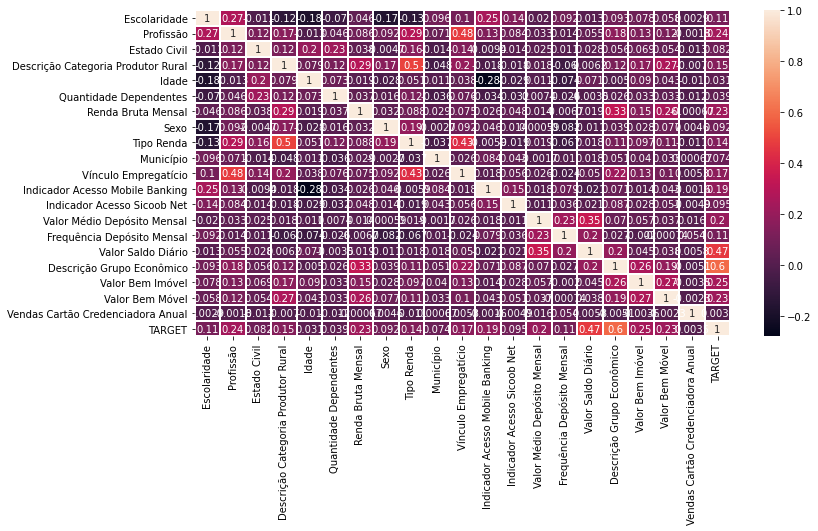

In [33]:
cor=df_base_prep.iloc[i]

correlacao = cor.corr()

# plotando o gráfico
fig, ax = plt.pyplot.subplots(figsize=(12,6))
sns.heatmap(correlacao, 
        xticklabels=correlacao.columns,
        yticklabels=correlacao.columns,
        linewidths=1,
           annot=True)

In [34]:
pd.DataFrame(gbr.feature_importances_, index=list(X.columns), columns=['Peso']).sort_values(by=['Peso'], ascending=False)

,Peso
Descrição Grupo Econômico,0.457580
Valor Saldo Diário,0.247313
Valor Bem Móvel,0.068106
Renda Bruta Mensal,0.045855
Profissão,0.037655
Indicador Acesso Mobile Banking,0.033830
Valor Médio Depósito Mensal,0.027608
Valor Bem Imóvel,0.017476
Sexo,0.013955
Município,0.009786


In [35]:
valorPredict= gbr.predict(df_base_prep[features])

In [36]:
df_base.head(1)

,Número Cooperativa,Número CPF/CNPJ,Nome Cliente,Número PA,Nome PA,Escolaridade,Estado Civil,Descrição Categoria Produtor Rural,Data Início Relacionamento,Tempo Relacionamento,Idade,Profissão,Quantidade Dependentes,Renda Bruta Mensal,Sexo,Tipo Renda,Vínculo Empregatício,Município,Quantidade Produtos PF,Indicador Acesso Mobile Banking,Indicador Acesso Sicoob Empresarial,Indicador Acesso Sicoob Net,Indicador Produto Conta Capital,Qtd Meses Associação,Resultado PDS Ano,Média Anual Resultado PDS,Valor Médio Depósito Mensal,Frequência Depósito Mensal,Indicador Associado,Descrição Grupo Econômico,Valor Bem Imóvel,Valor Bem Móvel,Valor Saldo Diário,Indicador Poupador,Vendas Cartão Credenciadora Anual
0,3010,12744580724,THALICA LORENZONI CAMINOTTE,4,SICOOB - PA MARECHAL FLORIANO,ENSINO FUNDAMENTAL COMPLETO (ANTIGO 1º GRAU),SOLTEIRO(A),NÃO SE APLICA,2015-08-07,59,28,ESTUDANTE,0,0.0,F,NÃO INFORMADO,OUTRAS OCUPAÇÕES NÃO REMUNERADAS,CARIACICA,1,NÃO,NÃO,NÃO,NÃO,0.0,0.0,0.0,0.0,0.0,0.0,NÃO INFORMADO,0.0,0.0,2325.07,1,0.0


In [41]:
# gerando base com valor de margem de serviços estimada para o período de maturação de relacionamento
df_output_predict=df_base[['Número Cooperativa', 'Número PA', 'Nome PA',
                         'Número CPF/CNPJ', 'Nome Cliente', 'Descrição Grupo Econômico',
                         'Valor Bem Móvel', 'Renda Bruta Mensal', 'Profissão',
                         'Valor Saldo Diário','Indicador Associado']].copy()

df_output_predict['Margem Serviços Mensal'] = valorPredict
df_output_predict=df_output_predict[df_output_predict['Indicador Associado']==0.0]

In [42]:
df_output_predict.to_excel('../data/poupanca predict.xlsx',
                           sheet_name='poupadores', 
                           header=True, index=False, 
                           merge_cells=False, encoding='utf-8', )

## Análise de Dados

In [67]:
# importando base para cesta de produtos
path_dfprod='../data/df_clientes_produtos.csv'
df_prod=pd.read_csv(path_dfprod, header=0, sep=';', encoding='utf-8', decimal="."
                  , dtype={'NUM_CPFCNPJ': 'object'})

# filtrando sócios PF
df_prod=df_prod[(df_prod['SIGLA_TIPO_PESSOA']=='PF') & df_prod['BOL_ASSOCIADO']==1]

# gerando features da cesta de compras
features_cesta=[x for x in list(df_prod.columns) if x[:5] == 'PROD_']

df_prod=df_prod[features_cesta]

In [77]:
pd.DataFrame(df_prod.sum()/df_prod.shape[0], columns=['Suporte']).sort_values(by='Suporte', ascending=False)

,Suporte
PROD_CCO_CORRENTE,0.703539
PROD_CAR_CLASSICO,0.380436
PROD_POP_POUPANCA,0.290046
PROD_SEG_VIDA_INDIVIDUAL,0.075019
PROD_CAR_GOLD,0.069752
PROD_CCO_SALARIO,0.058664
PROD_CRE_EMPRÉSTIMO_PESSOAL_SEM_CONSIGNAÇÃO,0.052204
PROD_CRE_EMPRÉSTIMO_PRÉ_APROVADO,0.047799
PROD_SEG_AUTOMÓVEL,0.044847
PROD_INV_MÉDIO_INVESTIDOR,0.039347


In [90]:
for x in list(df_prod.columns):
     df_prod[x]=df_prod[x].astype('int16') 

In [93]:
suporte=0.001
cesta=apriori(df_prod, min_support=suporte, use_colnames=True)

In [161]:
regras=association_rules(cesta, metric='lift', min_threshold=2)

# filtrando associações com Poupança
#regras=regras[regras['antecedents'].astype(str).str.contains('PROD_POP_POUPANCA','PROD_POP_POUPANCA_KIDS')]

# gerando associações importantes de poupança com outros produtos
regras=regras[(regras['antecedents']==frozenset({'PROD_POP_POUPANCA'})) | 
              (regras['antecedents']==frozenset({'PROD_POP_POUPANCA_KIDS'}))]

# ordenando a partir da relação mais forte
regras.sort_values(by=['lift', 'support'], inplace=True, ascending=False)

regras

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1015,(PROD_POP_POUPANCA),"(PROD_CRE_EMPRÉSTIMO_PESSOAL_CONSIGNADO, PROD_PRE_PREVIDENCIA_PRIVADA)",0.290046,0.002469,0.001961,0.006761,2.738760,0.001245,1.004321
2317,(PROD_POP_POUPANCA),"(PROD_CCO_CORRENTE, PROD_CRE_EMPRÉSTIMO_PESSOAL_CONSIGNADO, PROD_PRE_PREVIDENCIA_PRIVADA)",0.290046,0.002469,0.001961,0.006761,2.738760,0.001245,1.004321
1629,(PROD_POP_POUPANCA),"(PROD_SEG_VIDA_MULHER, PROD_CCO_CORRENTE, PROD_PRE_PREVIDENCIA_PRIVADA)",0.290046,0.001752,0.001346,0.004639,2.647364,0.000837,1.002900
531,(PROD_POP_POUPANCA),"(PROD_SEG_VIDA_MULHER, PROD_PRE_PREVIDENCIA_PRIVADA)",0.290046,0.001871,0.001391,0.004795,2.563368,0.000848,1.002938
1417,(PROD_POP_POUPANCA),"(PROD_CCO_CORRENTE, PROD_SEG_AUTOMÓVEL, PROD_CRE_EMPRÉSTIMO_PESSOAL_CONSIGNADO)",0.290046,0.002006,0.001432,0.004939,2.461811,0.000851,1.002947
353,(PROD_POP_POUPANCA),"(PROD_SEG_AUTOMÓVEL, PROD_CRE_EMPRÉSTIMO_PESSOAL_CONSIGNADO)",0.290046,0.002037,0.001439,0.004963,2.435768,0.000848,1.002940
1587,(PROD_POP_POUPANCA),"(PROD_SEG_RESIDENCIAL, PROD_CCO_CORRENTE, PROD_PRE_PREVIDENCIA_PRIVADA)",0.290046,0.002256,0.001523,0.005250,2.326819,0.000868,1.003010
485,(PROD_POP_POUPANCA),"(PROD_SEG_RESIDENCIAL, PROD_PRE_PREVIDENCIA_PRIVADA)",0.290046,0.002302,0.001540,0.005310,2.307167,0.000873,1.003025
1449,(PROD_POP_POUPANCA),"(PROD_CCO_CORRENTE, PROD_SEG_AUTOMÓVEL, PROD_PRE_PREVIDENCIA_PRIVADA)",0.290046,0.003129,0.002076,0.007156,2.286994,0.001168,1.004056
369,(PROD_POP_POUPANCA),"(PROD_SEG_AUTOMÓVEL, PROD_PRE_PREVIDENCIA_PRIVADA)",0.290046,0.003220,0.002110,0.007276,2.260013,0.001177,1.004086
